In [1]:
import glob
import sqlite3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


##  Read cellProfiler tracking outputs

In [ ]:
# read cellProfiler outputs
dir_path = "./segs"
conn = sqlite3.connect(os.path.join(dir_path, "cell_track.db"))
cell_track_db_df = pd.read_sql_query("SELECT * FROM Per_Object", conn)
relation_df = pd.read_sql_query("SELECT * FROM Per_Relationships", conn)

In [ ]:
cell_track_db_df[:2]

,ImageNumber,ObjectNumber,Cell_Number_Object_Number,Cell_AreaShape_Area,Cell_AreaShape_BoundingBoxArea,Cell_AreaShape_BoundingBoxMaximum_X,Cell_AreaShape_BoundingBoxMaximum_Y,Cell_AreaShape_BoundingBoxMinimum_X,Cell_AreaShape_BoundingBoxMinimum_Y,Cell_AreaShape_Center_X,...,Cell_TrackObjects_LinkingDistance,Cell_TrackObjects_MergeScore,Cell_TrackObjects_MitosisScore,Cell_TrackObjects_MovementModel,Cell_TrackObjects_ParentImageNumber,Cell_TrackObjects_ParentObjectNumber,Cell_TrackObjects_SplitScore,Cell_TrackObjects_StandardDeviation,Cell_TrackObjects_TrajectoryX,Cell_TrackObjects_TrajectoryY
0,1,1,1,18034.0,24050.0,428.0,581.0,243.0,451.0,329.392924,...,NaN,None,None,-1,0,0,None,NaN,0,0
1,1,2,2,41236.0,59024.0,1422.0,1559.0,1174.0,1321.0,1296.094238,...,NaN,None,None,-1,0,0,None,NaN,0,0


In [ ]:
relation_df[:2]

,relationship_type_id,image_number1,object_number1,image_number2,object_number2
0,1,1,1,2,1
1,1,1,2,2,2


In [ ]:
cell_track_db_df.columns

Index(['ImageNumber', 'ObjectNumber', 'Cell_Number_Object_Number',
       'Cell_AreaShape_Area', 'Cell_AreaShape_BoundingBoxArea',
       'Cell_AreaShape_BoundingBoxMaximum_X',
       'Cell_AreaShape_BoundingBoxMaximum_Y',
       'Cell_AreaShape_BoundingBoxMinimum_X',
       'Cell_AreaShape_BoundingBoxMinimum_Y', 'Cell_AreaShape_Center_X',
       'Cell_AreaShape_Center_Y', 'Cell_AreaShape_Compactness',
       'Cell_AreaShape_ConvexArea', 'Cell_AreaShape_Eccentricity',
       'Cell_AreaShape_EquivalentDiameter', 'Cell_AreaShape_EulerNumber',
       'Cell_AreaShape_Extent', 'Cell_AreaShape_FormFactor',
       'Cell_AreaShape_MajorAxisLength', 'Cell_AreaShape_MaxFeretDiameter',
       'Cell_AreaShape_MaximumRadius', 'Cell_AreaShape_MeanRadius',
       'Cell_AreaShape_MedianRadius', 'Cell_AreaShape_MinFeretDiameter',
       'Cell_AreaShape_MinorAxisLength', 'Cell_AreaShape_Orientation',
       'Cell_AreaShape_Perimeter', 'Cell_AreaShape_Solidity',
       'Cell_Location_Center_X', 'Cell_Loc

## Read and Visualize Trajectories

In [2]:
from cellpose.io import imread
from pathlib import Path
dir_path = Path('D://xing-vimentin-dic-pipeline//src//livecell_dev//cxa-data//june_2022_data//day0_Notreat_Group1_wellA1_RI_MIP_stitched')
img_list = sorted(glob.glob(str(dir_path/"*tif")))
imgs = [imread(f) for f in img_list]
nimg = len(imgs)
imgs_subset = imgs[:5] # for quick test

c:/Users/dummy/Anaconda3/envs/cv-general/lib/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
def generate_traj_df(df):
    """
    Record img_num and obj_num(or idx_num in Per_Object) in all traj into one table, label=rowIndex+1
    Returns
        a tuple of dataframe
    """
    t_span = max(df["ImageNumber"])
    traj_label = df["Cell_TrackObjects_Label"].values
    traj_label = np.sort(np.unique(traj_label[traj_label > 0]))
    num_trajectories = len(traj_label)  # the quantity of trajectories
    print("#trajectories:", num_trajectories)

    t_col = [str(i + 1) for i in range(t_span)]

    # initialize pandas dataframes
    traj_df = -1 * np.ones((num_trajectories, t_span), dtype=np.int)
    traj_df = pd.DataFrame(traj_df, columns=t_col)

    traj_row_idx_df = -1 * np.ones((num_trajectories, t_span), dtype=np.int)
    traj_row_idx_df = pd.DataFrame(traj_row_idx_df, columns=t_col)

    for traj_i in range(num_trajectories):
        cur_traj_label = traj_label[traj_i]
        # find all the index that have the same label(in the same trajectory)
        same_traj_label_indices = df["Cell_TrackObjects_Label"] == int(cur_traj_label)
        row_idx_list = df[same_traj_label_indices].index.tolist()
        for row_idx in row_idx_list:
            time_index = df["ImageNumber"][row_idx]
            traj_df[str(time_index)][traj_i] = df["ObjectNumber"][row_idx]
            traj_row_idx_df[str(time_index)][traj_i] = row_idx
    return traj_df, traj_row_idx_df

In [28]:
traj_labels = cell_track_db_df["Cell_TrackObjects_Label"].values
traj_labels = np.unique(traj_labels[traj_labels > 0])
traj_labels

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [29]:
traj_df, traj_row_idx_df = generate_traj_df(cell_track_db_df)
traj_df.insert(loc=0, column="traj_label", value=traj_labels)
traj_df

#trajectories: 7


C:/Users/dummy/AppData/Local/Temp/ipykernel_53820/3495105297.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  traj_df = -1 * np.ones((num_trajectories, t_span), dtype=np.int)
C:/Users/dummy/AppData/Local/Temp/ipykernel_53820/3495105297.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

,traj_label,1,2,3,4,5
0,1,1,1,1,1,1
1,2,2,2,2,2,2
2,3,3,3,3,3,3
3,4,4,4,4,4,4
4,5,5,5,5,5,5
5,6,6,6,6,6,6
6,7,7,7,7,7,7


In [8]:
traj_row_idx_df

,1,2,3,4,5
0,0,7,14,21,28
1,1,8,15,22,29
2,2,9,16,23,30
3,3,10,17,24,31
4,4,11,18,25,32
5,5,12,19,26,33
6,6,13,20,27,34


In [9]:
cell_track_db_df[:2]

,ImageNumber,ObjectNumber,Cell_Number_Object_Number,Cell_AreaShape_Area,Cell_AreaShape_BoundingBoxArea,Cell_AreaShape_BoundingBoxMaximum_X,Cell_AreaShape_BoundingBoxMaximum_Y,Cell_AreaShape_BoundingBoxMinimum_X,Cell_AreaShape_BoundingBoxMinimum_Y,Cell_AreaShape_Center_X,...,Cell_TrackObjects_LinkingDistance,Cell_TrackObjects_MergeScore,Cell_TrackObjects_MitosisScore,Cell_TrackObjects_MovementModel,Cell_TrackObjects_ParentImageNumber,Cell_TrackObjects_ParentObjectNumber,Cell_TrackObjects_SplitScore,Cell_TrackObjects_StandardDeviation,Cell_TrackObjects_TrajectoryX,Cell_TrackObjects_TrajectoryY
0,1,1,1,18034.0,24050.0,428.0,581.0,243.0,451.0,329.392924,...,NaN,None,None,-1,0,0,None,NaN,0,0
1,1,2,2,41236.0,59024.0,1422.0,1559.0,1174.0,1321.0,1296.094238,...,NaN,None,None,-1,0,0,None,NaN,0,0


In [22]:
MAX_X_COL = "Cell_AreaShape_BoundingBoxMaximum_X"
MAX_Y_COL = "Cell_AreaShape_BoundingBoxMaximum_Y"
MIN_X_COL = "Cell_AreaShape_BoundingBoxMinimum_X"
MIN_Y_COL = "Cell_AreaShape_BoundingBoxMinimum_Y"
AREA_CENTER_X = "Cell_AreaShape_Center_X"
AREA_CENTER_Y = "Cell_AreaShape_Center_Y"
IMG_NUM_COL = "ImageNumber"
max_xs = cell_track_db_df[MAX_X_COL]
max_ys = cell_track_db_df[MAX_Y_COL]
min_xs = cell_track_db_df[MIN_X_COL]
min_ys = cell_track_db_df[MIN_Y_COL]

MovieWriter ffmpeg unavailable; using Pillow instead.


row_index: 0
(243, 428, 451, 581)
row_index: 7
(243, 428, 451, 581)
row_index: 14
(243, 428, 451, 581)
row_index: 21
(243, 428, 451, 581)
row_index: 28
(243, 428, 451, 581)


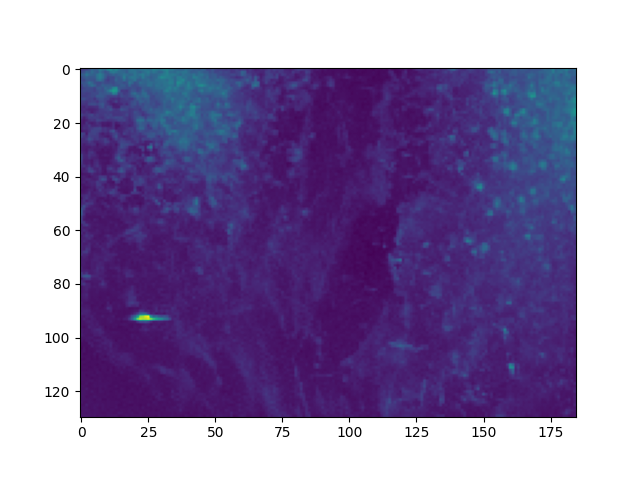

MovieWriter ffmpeg unavailable; using Pillow instead.


row_index: 1
(1174, 1422, 1321, 1559)
row_index: 8
(1174, 1422, 1321, 1559)
row_index: 15
(1174, 1422, 1321, 1559)
row_index: 22
(1174, 1422, 1321, 1559)
row_index: 29
(1174, 1422, 1321, 1559)


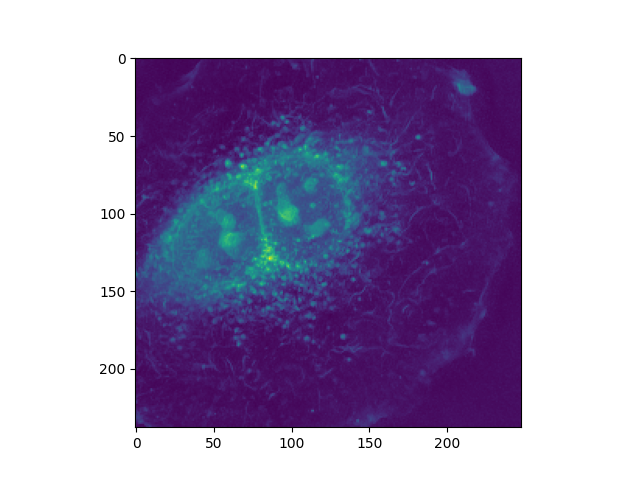

MovieWriter ffmpeg unavailable; using Pillow instead.


row_index: 2
(1223, 1425, 1779, 2001)
row_index: 9
(1223, 1425, 1779, 2001)
row_index: 16
(1223, 1425, 1779, 2001)
row_index: 23
(1223, 1425, 1779, 2001)
row_index: 30
(1223, 1425, 1779, 2001)


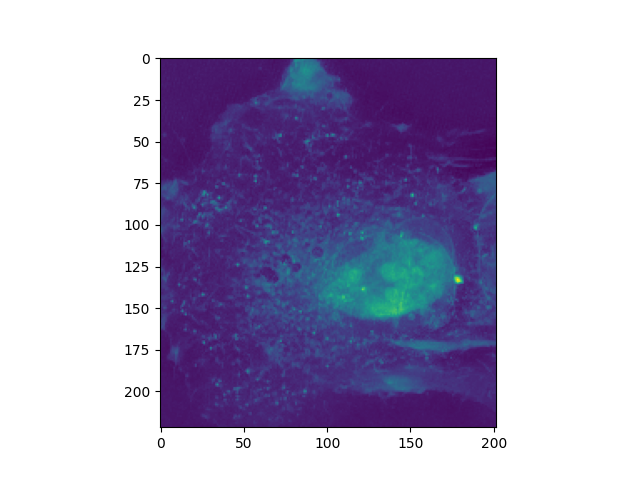

MovieWriter ffmpeg unavailable; using Pillow instead.


row_index: 3
(1261, 1510, 0, 294)
row_index: 10
(1261, 1510, 0, 294)
row_index: 17
(1261, 1510, 0, 294)
row_index: 24
(1261, 1510, 0, 294)
row_index: 31
(1261, 1510, 0, 294)


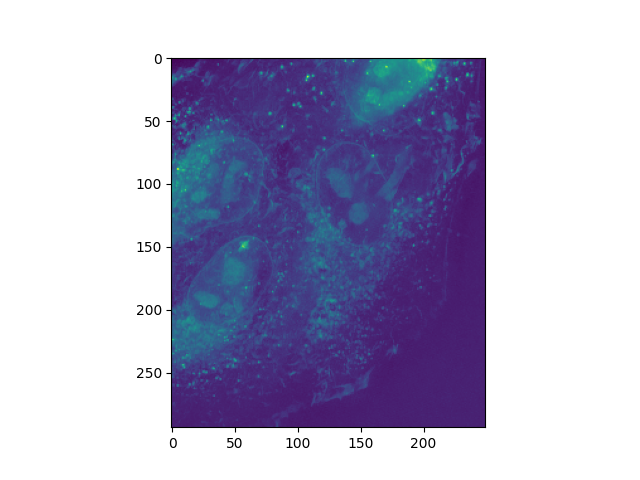

MovieWriter ffmpeg unavailable; using Pillow instead.


row_index: 4
(1399, 1558, 1751, 1925)
row_index: 11
(1399, 1558, 1751, 1925)
row_index: 18
(1399, 1558, 1751, 1925)
row_index: 25
(1399, 1558, 1751, 1925)
row_index: 32
(1399, 1558, 1751, 1925)


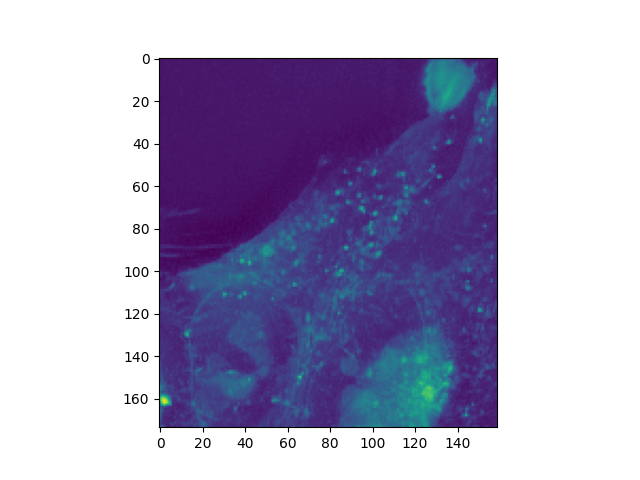

MovieWriter ffmpeg unavailable; using Pillow instead.


row_index: 5
(2044, 2185, 792, 1000)
row_index: 12
(2044, 2185, 792, 1000)
row_index: 19
(2044, 2185, 792, 1000)
row_index: 26
(2044, 2185, 792, 1000)
row_index: 33
(2044, 2185, 792, 1000)


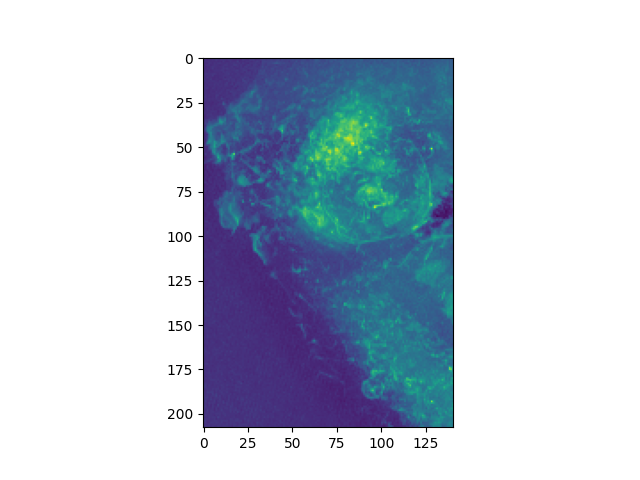

MovieWriter ffmpeg unavailable; using Pillow instead.


row_index: 6
(2167, 2307, 793, 1105)
row_index: 13
(2167, 2307, 793, 1105)
row_index: 20
(2167, 2307, 793, 1105)
row_index: 27
(2167, 2307, 793, 1105)
row_index: 34
(2167, 2307, 793, 1105)


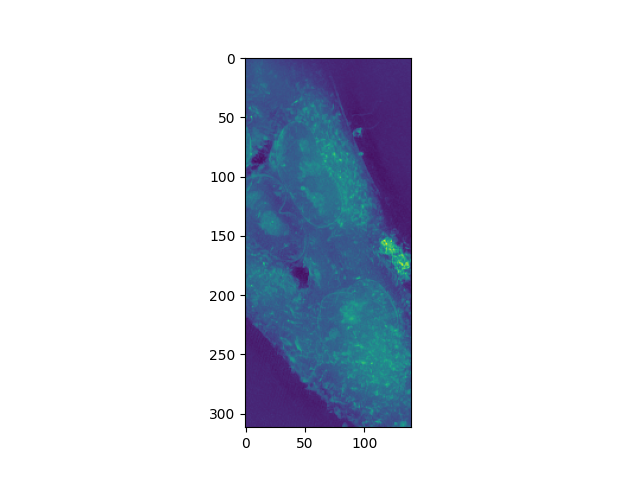

In [25]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def visualize_traj(traj_row_indices, imgs, cell_track_db_df, save_path="./test.gif"):
    fig, ax = plt.subplots()
    def init():
        pass
    def update(frame):
        ax.cla()
        ax.imshow(frame)
        return []
    frame_imgs = []
    for row_idx in traj_row_indices:
        max_x = cell_track_db_df[MAX_X_COL][row_idx]
        max_y = cell_track_db_df[MAX_Y_COL][row_idx]
        min_x = cell_track_db_df[MIN_X_COL][row_idx]
        min_y = cell_track_db_df[MIN_Y_COL][row_idx]
        
        min_x, max_x, min_y, max_y = int(min_x), int(max_x), int(min_y), int(max_y)

        # Note the index difference here: 1-base for CellProfiler and 0-base for list index
        img_idx = cell_track_db_df[IMG_NUM_COL][row_idx] - 1
        img = imgs[img_idx]
        print("row_index:", row_idx)
        print((min_x, max_x, min_y, max_y))
        img_crop = img[min_y:max_y, min_x:max_x]
        frame_imgs.append(img_crop)

    ani = FuncAnimation(fig, update, frames=frame_imgs,
                    init_func=None, blit=True)
    ani.save(save_path)

output_dir = Path("./gifs/")
for i in range(traj_row_idx_df.shape[0]):
    save_path = output_dir/f"traj_{i}.gif"
    visualize_traj(traj_row_idx_df.iloc[i, :], imgs_subset, cell_track_db_df, save_path=save_path)
    plt.show()